In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [19]:
transform = transforms.ToTensor()

test_dataset = torchvision.datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

class PoisonedTestDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, poison_ratio=0.2):
        self.dataset = dataset
        self.poison_ratio = poison_ratio
        self.poison_flags = np.zeros(len(dataset), dtype=int)

        num_poison = int(len(dataset) * poison_ratio)
        poison_indices = np.random.choice(len(dataset), num_poison, replace=False)
        self.poison_flags[poison_indices] = 1

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        poison_flag = self.poison_flags[idx]
        return img, label, poison_flag

poisoned_test_dataset = PoisonedTestDataset(test_dataset, poison_ratio=0.2)

test_loader = torch.utils.data.DataLoader(
    poisoned_test_dataset,
    batch_size=128,
    shuffle=False
)

print("Test samples:", len(poisoned_test_dataset))
print("Poisoned samples:", poisoned_test_dataset.poison_flags.sum())


Test samples: 10000
Poisoned samples: 2000


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),  # penultimate layer
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [21]:
model = SimpleCNN().to(device)
model.load_state_dict(
    torch.load("../models/backdoored_model.pth", map_location=device)
)
model.eval()

print("✅ Backdoored model loaded")


✅ Backdoored model loaded


In [22]:
activations = []

def hook_fn(module, input, output):
    activations.append(output.detach().cpu())

hook = model.fc[0].register_forward_hook(hook_fn)


In [23]:
all_labels = []
all_poison_flags = []

with torch.no_grad():
    for images, labels, poison_flag in test_loader:
        images = images.to(device)
        _ = model(images)

        all_labels.extend(labels.numpy())
        all_poison_flags.extend(poison_flag.numpy())

hook.remove()

activations = torch.cat(activations, dim=0).numpy()
all_poison_flags = np.array(all_poison_flags)

print("Activation shape:", activations.shape)


Activation shape: (10000, 128)


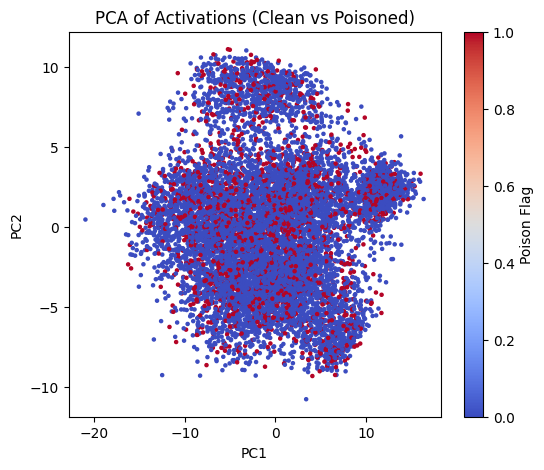

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(activations)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=all_poison_flags,
            cmap="coolwarm",
            s=5)
plt.title("PCA of Activations (Clean vs Poisoned)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Poison Flag")
plt.show()


In [25]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


In [26]:
cluster0_ratio = np.mean(all_poison_flags[cluster_labels == 0])
cluster1_ratio = np.mean(all_poison_flags[cluster_labels == 1])

poison_cluster = 0 if cluster0_ratio > cluster1_ratio else 1
predicted_poison = (cluster_labels == poison_cluster).astype(int)


In [27]:
precision = precision_score(all_poison_flags, predicted_poison)
recall = recall_score(all_poison_flags, predicted_poison)
f1 = f1_score(all_poison_flags, predicted_poison)

print("📊 Detection Results (KMeans)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


📊 Detection Results (KMeans)
Precision: 0.2067
Recall:    0.5525
F1-score:  0.3009


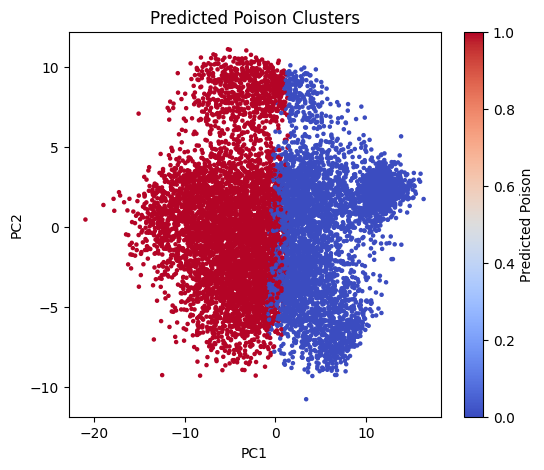

In [28]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=predicted_poison,
            cmap="coolwarm",
            s=5)
plt.title("Predicted Poison Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Predicted Poison")
plt.show()


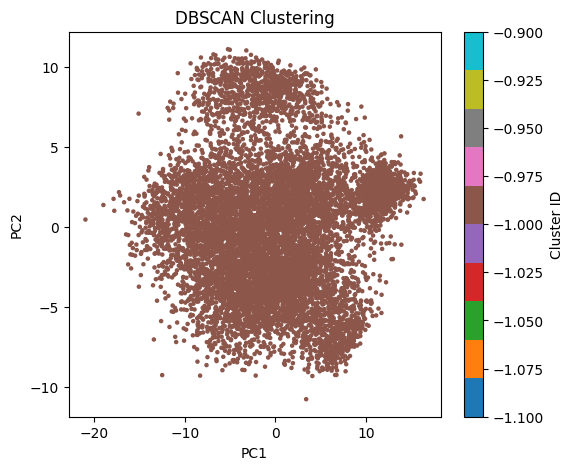

In [29]:
dbscan = DBSCAN(eps=0.8, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=db_labels,
            cmap="tab10",
            s=5)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster ID")
plt.show()
